In [1]:
from google.colab import drive
drive.mount('/content/drive')

input_path = '/content/drive/MyDrive/Deep Learning Group 12/Deep Learning Group 12/traffic.csv'

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
df = pd.read_csv(input_path)

# Display basic information about the dataset
print(df.head())
print(df.info())

# Convert datetime to proper format
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# Extract time-based features
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month
df['year'] = df['DateTime'].dt.year

# Check data distribution by junction
junction_counts = df.groupby('Junction').size()
print("Data points per junction:")
print(junction_counts)

# Split data by time (2015-2016 for training, 2017 for validation)
train_data = df[df['DateTime'].dt.year < 2017].copy()
val_data = df[df['DateTime'].dt.year == 2017].copy()

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

# Check if we have validation data for each junction
val_junction_counts = val_data.groupby('Junction').size()
print("Validation data points per junction:")
print(val_junction_counts)

# Normalize the data
scaler = MinMaxScaler()
df['Vehicles_scaled'] = scaler.fit_transform(df[['Vehicles']])
train_data['Vehicles_scaled'] = scaler.transform(train_data[['Vehicles']])
val_data['Vehicles_scaled'] = scaler.transform(val_data[['Vehicles']])

Using device: cuda
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None
Data points per junction:
Junction
1    14592
2    14592
3    14592
4     4344
dtype: int64
Training data shape: (30744, 8)
Validation data shape: (17376, 8)
Validation data points per junction:
Junction
1    4344
2    4344
3    4344
4    4344
dtype: int

In [4]:
def create_sequences(data, junction_id, seq_length=24):
    """
    Create sequences of data for a specific junction with a given sequence length.
    """
    junction_data = data[data['Junction'] == junction_id].copy()
    junction_data = junction_data.sort_values('DateTime')

    # Check if we have enough data to create sequences
    if len(junction_data) <= seq_length:
        print(f"Warning: Junction {junction_id} has only {len(junction_data)} data points, which is not enough to create sequences of length {seq_length}")
        return np.array([]), np.array([])

    X, y = [], []
    for i in range(len(junction_data) - seq_length):
        X.append(junction_data['Vehicles_scaled'].iloc[i:i+seq_length].values)
        y.append(junction_data['Vehicles_scaled'].iloc[i+seq_length])

    return np.array(X), np.array(y)

# Create sequences for each junction
junctions = df['Junction'].unique()
X_train_all = []
y_train_all = []
X_val_all = []
y_val_all = []

for junction in junctions:
    X_train, y_train = create_sequences(train_data, junction)
    X_val, y_val = create_sequences(val_data, junction)

    # Only add non-empty sequences
    if X_train.size > 0 and y_train.size > 0:
        X_train_all.append(X_train)
        y_train_all.append(y_train)
        print(f"Junction {junction} - Training sequences: {len(X_train)}")
    else:
        print(f"Junction {junction} - No training sequences created")

    if X_val.size > 0 and y_val.size > 0:
        X_val_all.append(X_val)
        y_val_all.append(y_val)
        print(f"Junction {junction} - Validation sequences: {len(X_val)}")
    else:
        print(f"Junction {junction} - No validation sequences created")

# Check if we have any sequences
if not X_train_all or not y_train_all or not X_val_all or not y_val_all:
    raise ValueError("No sequences were created. Please check your data.")

# Combine data from all junctions
X_train = np.vstack(X_train_all)
y_train = np.concatenate(y_train_all)
X_val = np.vstack(X_val_all)
y_val = np.concatenate(y_val_all)

# Reshape for CNN input (PyTorch: [batch, channels, seq_length])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

Junction 1 - Training sequences: 10224
Junction 1 - Validation sequences: 4320
Junction 2 - Training sequences: 10224
Junction 2 - Validation sequences: 4320
Junction 3 - Training sequences: 10224
Junction 3 - Validation sequences: 4320
Junction 4 - No training sequences created
Junction 4 - Validation sequences: 4320
X_train shape: (30672, 1, 24)
y_train shape: (30672,)
X_val shape: (17280, 1, 24)
y_val shape: (17280,)


In [5]:
class TrafficDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [6]:
train_dataset = TrafficDataset(X_train_tensor, y_train_tensor)
val_dataset = TrafficDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [7]:
class TrafficCNN(nn.Module):
    def __init__(self, seq_length):
        super(TrafficCNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Calculate the size after first convolution and pooling
        conv1_output_size = seq_length - 3 + 1  # (L - kernel_size + 1)
        pool1_output_size = (conv1_output_size) // 2  # After max pooling

        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Calculate the size after second convolution and pooling
        conv2_output_size = pool1_output_size - 3 + 1
        pool2_output_size = (conv2_output_size) // 2

        # Third convolutional layer
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3)
        self.relu3 = nn.ReLU()

        # Calculate the size after third convolution
        conv3_output_size = pool2_output_size - 3 + 1

        # Flatten layer
        self.flatten_size = 128 * conv3_output_size

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc1_relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.fc2_relu = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))

        # Flatten
        x = x.view(-1, self.flatten_size)

        # Fully connected layers
        x = self.dropout(self.fc1_relu(self.fc1(x)))
        x = self.fc2_relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Create model
seq_length = 24
model = TrafficCNN(seq_length).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

TrafficCNN(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu3): ReLU()
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc1_relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc2_relu): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


Epoch 1/50, Train Loss: 0.002540, Val Loss: 0.003516, LR: 0.001000
Epoch 2/50, Train Loss: 0.001214, Val Loss: 0.002308, LR: 0.001000
Epoch 3/50, Train Loss: 0.001087, Val Loss: 0.002775, LR: 0.001000
Epoch 4/50, Train Loss: 0.001015, Val Loss: 0.002976, LR: 0.001000
Epoch 5/50, Train Loss: 0.000980, Val Loss: 0.002702, LR: 0.001000
Epoch 6/50, Train Loss: 0.000950, Val Loss: 0.002222, LR: 0.001000
Epoch 7/50, Train Loss: 0.000915, Val Loss: 0.002782, LR: 0.001000
Epoch 8/50, Train Loss: 0.000893, Val Loss: 0.003196, LR: 0.001000
Epoch 9/50, Train Loss: 0.000896, Val Loss: 0.002569, LR: 0.001000
Epoch 10/50, Train Loss: 0.000878, Val Loss: 0.002225, LR: 0.001000
Epoch 11/50, Train Loss: 0.000854, Val Loss: 0.002904, LR: 0.001000
Epoch 12/50, Train Loss: 0.000855, Val Loss: 0.002616, LR: 0.000200
Epoch 13/50, Train Loss: 0.000776, Val Loss: 0.002364, LR: 0.000200
Epoch 14/50, Train Loss: 0.000772, Val Loss: 0.002179, LR: 0.000200
Epoch 15/50, Train Loss: 0.000765, Val Loss: 0.002380, LR

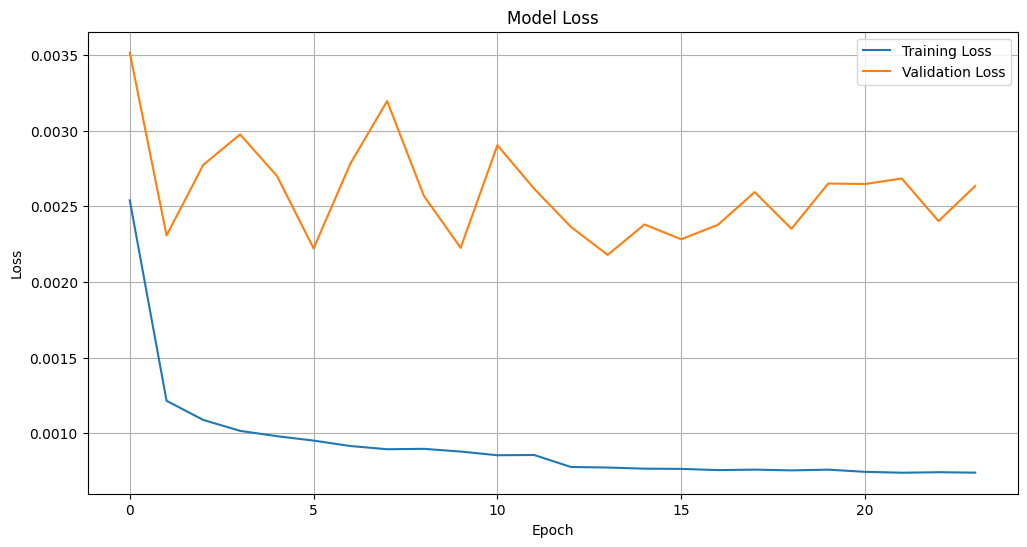

Mean Squared Error: 84.43
Root Mean Squared Error: 9.19
R² Score: 0.8743


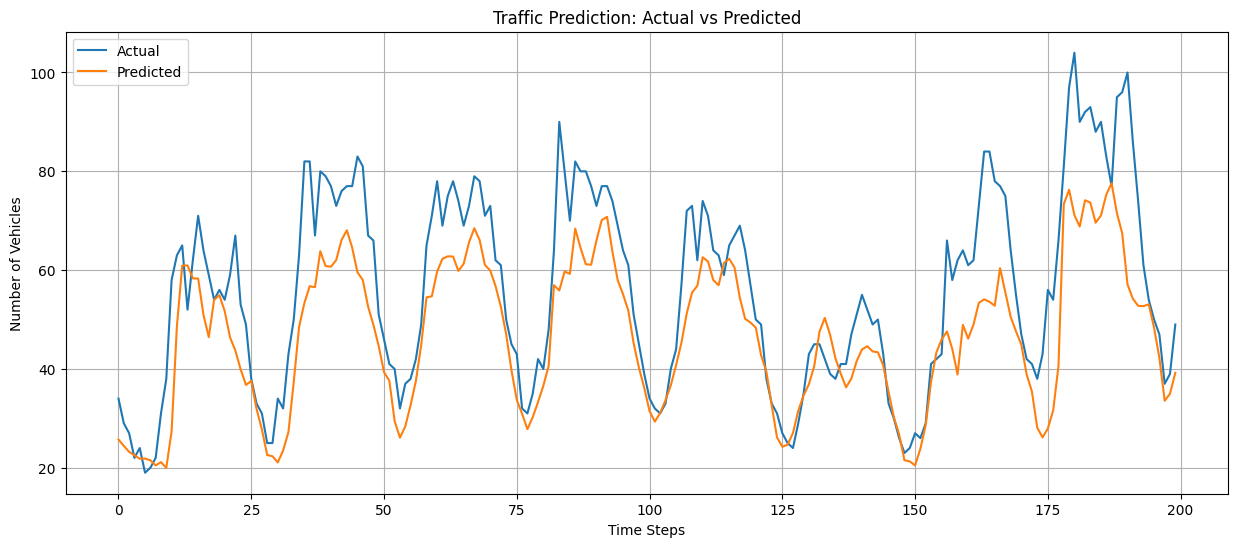

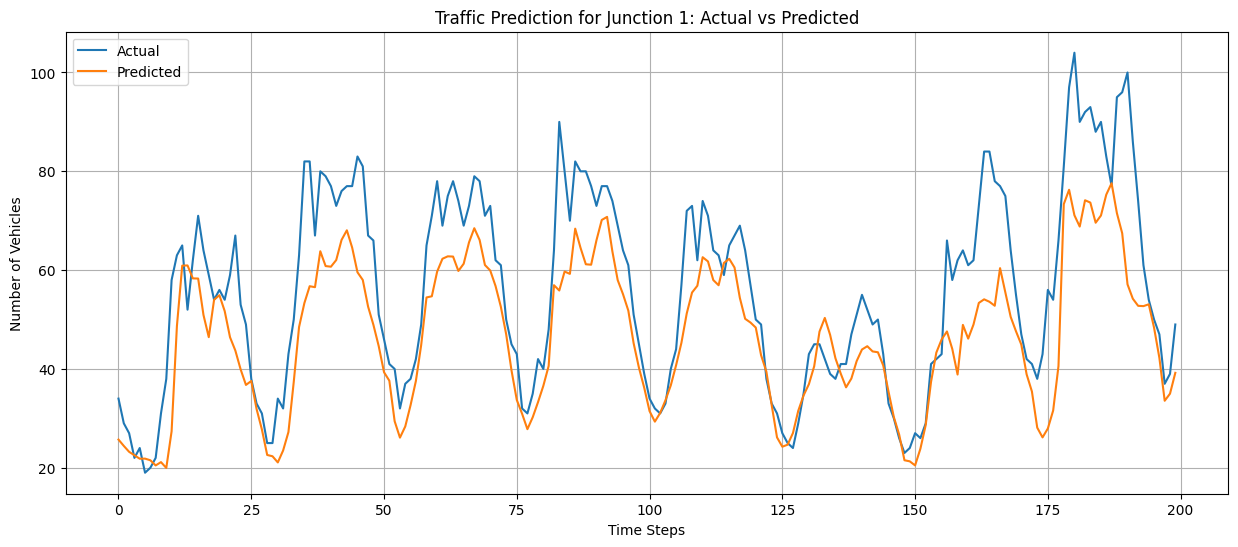

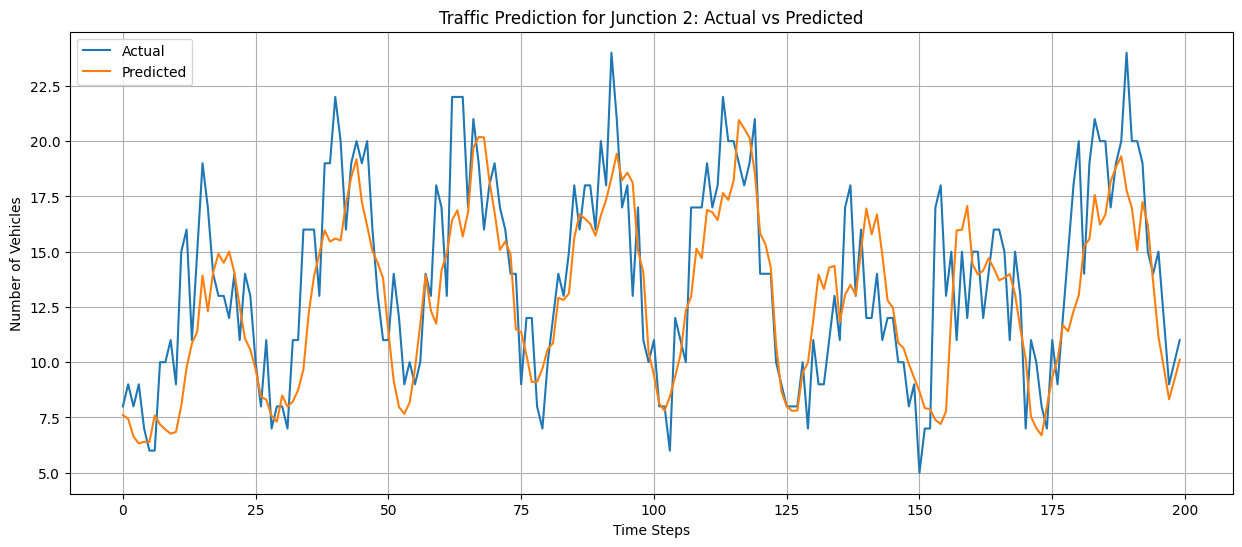

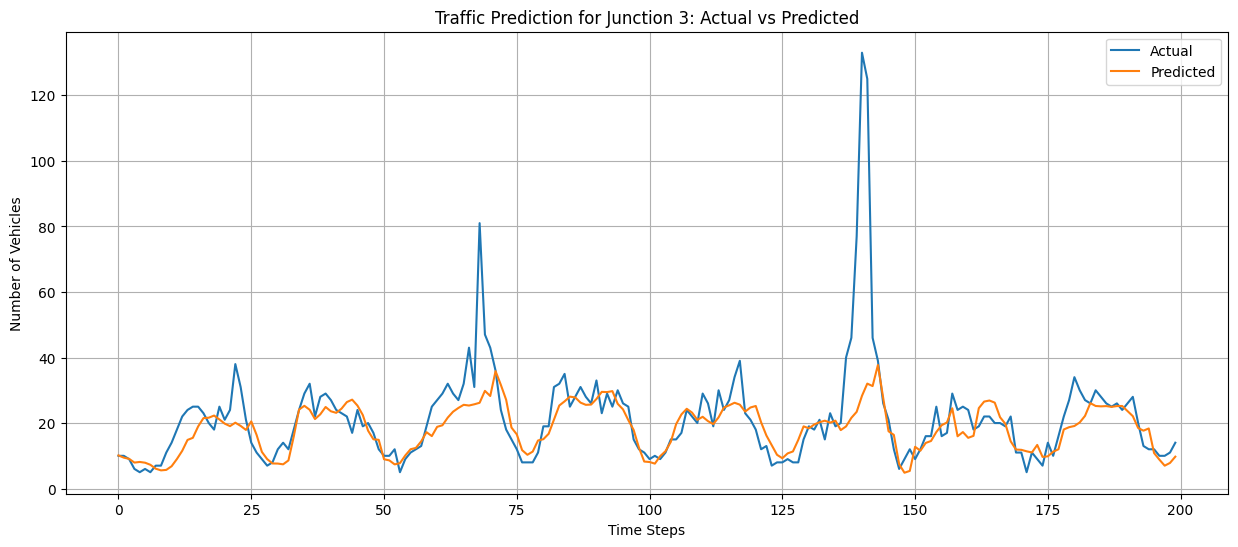

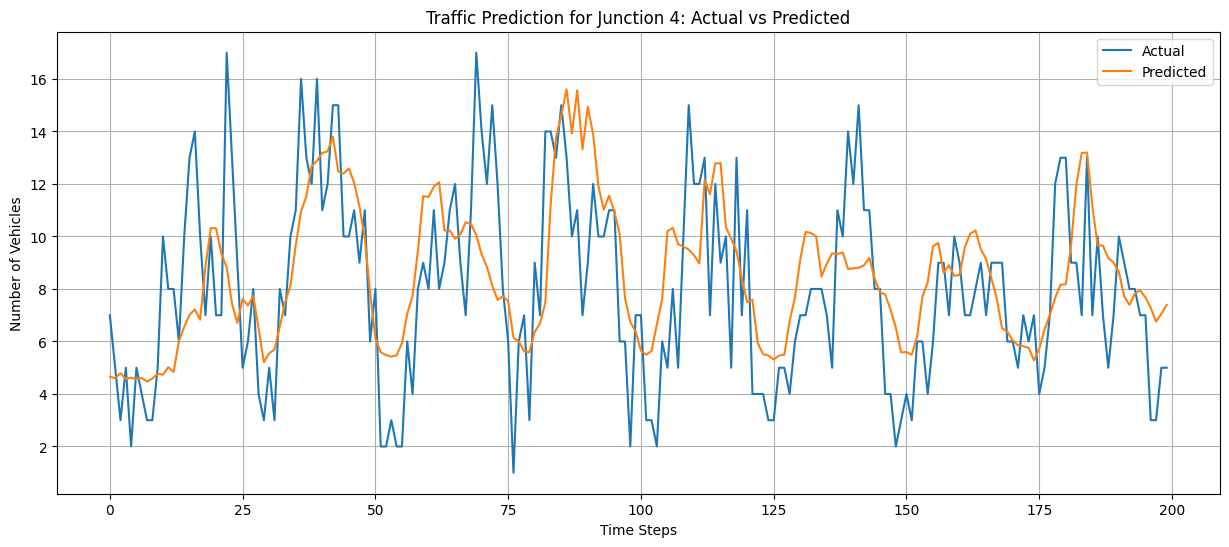

Model saved successfully.


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs, targets.unsqueeze(1))
                running_val_loss += val_loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Learning rate scheduler step
        scheduler.step(epoch_val_loss)

        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.6f}, '
              f'Val Loss: {epoch_val_loss:.6f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses


# Train the model
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in val_loader:
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())

y_pred_scaled = np.vstack(predictions)

# Inverse transform to get actual vehicle counts
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(15, 6))
plt.plot(y_true[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.title('Traffic Prediction: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()

# Visualize predictions for each junction separately
# First, we need to track which sequences belong to which junction
junction_val_indices = {}
current_idx = 0

for i, junction in enumerate(junctions):
    if i < len(X_val_all):  # Make sure we have validation data for this junction
        junction_val_indices[junction] = (current_idx, current_idx + len(X_val_all[i]))
        current_idx += len(X_val_all[i])

# Plot predictions for each junction
for junction, (start_idx, end_idx) in junction_val_indices.items():
    if end_idx > start_idx:  # Make sure we have data for this junction
        plt.figure(figsize=(15, 6))
        plt.plot(y_true[start_idx:start_idx+200], label='Actual')
        plt.plot(y_pred[start_idx:start_idx+200], label='Predicted')
        plt.title(f'Traffic Prediction for Junction {junction}: Actual vs Predicted')
        plt.xlabel('Time Steps')
        plt.ylabel('Number of Vehicles')
        plt.legend()
        plt.grid(True)
        plt.show()

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep Learning Group 12/Deep Learning Group 12/traffic_cnn_model_pytorch.pth')
print("Model saved successfully.")